In [1]:
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime as dt

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# benchmark stuff
from buildings_bench.data import load_pandas_dataset, benchmark_registry
from buildings_bench.evaluation.managers import DatasetMetricsManager
from buildings_bench import BuildingTypes

import torch


lag = 168

/projects/foundation/pemami/conda/foundation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [3]:
dataset_path = Path('/projects/foundation/eulp/BuildingsBench/')

In [4]:
metrics_manager = DatasetMetricsManager()

benchmark_registry = ['smart']

In [5]:
dataset = 'smart'

In [6]:
dataset_generator = load_pandas_dataset('smart', dataset_path)

In [7]:
dataset_generator.building_type

'residential'

In [8]:
building_types_mask = (BuildingTypes.RESIDENTIAL_INT * torch.ones([1,24,1])).bool()

In [9]:
for building_name, bldg_df in dataset_generator:
    if building_name == 'HomeB':
        break

In [10]:
bldg_df = bldg_df.tail(8785).head(8760)

In [11]:
bldg_df

,power,hour_x,hour_y,month_x,month_y,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,weekend_False,weekend_True
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.457379,0.000000,1.000000,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2016-01-01 01:00:00,0.429595,0.258819,0.965926,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2016-01-01 02:00:00,0.670407,0.500000,0.866025,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2016-01-01 03:00:00,0.437150,0.707107,0.707107,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2016-01-01 04:00:00,0.653374,0.866025,0.500000,5.000000e-01,0.866025,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 19:00:00,0.426538,-0.965926,0.258819,-2.449294e-16,1.000000,False,False,False,False,True,...,False,False,False,False,False,False,False,True,True,False
2016-12-30 20:00:00,0.473570,-0.866025,0.500000,-2.449294e-16,1.000000,False,False,False,False,True,...,False,False,False,False,False,False,False,True,True,False
2016-12-30 21:00:00,0.525701,-0.707107,0.707107,-2.449294e-16,1.000000,False,False,False,False,True,...,False,False,False,False,False,False,False,True,True,False


In [13]:
# import pytz
from datetime import timezone, timedelta
# dt_utc_aware = datetime.datetime.fromtimestamp(0, datetime.timezone.utc)

In [14]:
# new_timezone = pytz.timezone("US/Eastern")

In [15]:
weather_data = pd.read_csv('HomeB2016.csv')

In [16]:
weather_data['time'] = weather_data['time'].apply(lambda x: (dt.fromtimestamp(x, timezone.utc) - timedelta(hours=5)).strftime('%Y-%m-%d %H:%M:%S'))
weather_data.rename(columns={'time' : 'timestamp'}, inplace=True)
weather_data = weather_data.set_index('timestamp')
weather_data.index = pd.to_datetime(weather_data.index, format='%Y-%m-%d %H:%M:%S')

In [17]:
weather_data[weather_data.index.duplicated()]

,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
timestamp,,,,,,,,,,,,,


In [18]:
# weather_data = weather_data[~weather_data.index.duplicated(keep='first')]

In [19]:
weather_data

,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
timestamp,,,,,,,,,,,,,
2016-01-01 00:00:00,36.34,clear-night,0.61,10.00,Clear,29.86,1016.79,8.49,NaN,280.0,0.0000,24.22,0.00
2016-01-01 01:00:00,36.10,partly-cloudy-night,0.60,10.00,Mostly Cloudy,29.51,1016.14,8.60,0.75,284.0,0.0000,23.76,0.00
2016-01-01 02:00:00,35.56,clear-night,0.61,10.00,Clear,29.35,1015.94,7.72,NaN,279.0,0.0000,23.52,0.00
2016-01-01 03:00:00,35.40,clear-night,0.62,10.00,Clear,30.44,1015.95,5.79,NaN,266.0,0.0000,23.87,0.00
2016-01-01 04:00:00,35.67,clear-night,0.62,10.00,Clear,29.82,1015.79,7.16,NaN,267.0,0.0000,24.04,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 19:00:00,35.94,cloudy,0.75,9.51,Overcast,28.36,1013.10,10.54,1.00,188.0,0.0000,28.66,0.00
2016-12-30 20:00:00,38.08,partly-cloudy-night,0.71,8.91,Partly Cloudy,30.20,1013.09,12.62,0.31,197.0,0.0012,29.45,0.02
2016-12-30 21:00:00,36.65,rain,0.81,8.67,Light Rain,28.54,1012.47,12.22,NaN,198.0,0.0140,31.27,0.55


In [20]:
bldg_df['temperature'] = weather_data['temperature']

In [21]:
# bldg_df_1 = pd.merge(weather_data['temperature'], bldg_df, left_index=True, right_index=True)

In [22]:
# bldg_df_1 = bldg_df.join(weather_data['temperature'])

In [23]:
# bldg_df_1 = bldg_df_1.dropna()

In [24]:
# bldg_df_1 = bldg_df_1.resample(rule='H', closed='left', label='right').mean()

In [25]:
# bldg_df_1 = bldg_df_1.dropna()

In [26]:
# bldg_df_1 = bldg_df_1.head(8760)

In [27]:
bldg_train, bldg_test = train_test_split(bldg_df, test_size=0.25, shuffle=False)

In [28]:
forecaster = ForecasterAutoreg(
        regressor        = LGBMRegressor(max_depth=-1, n_estimators=100, n_jobs=24),
        lags             = lag
    )

In [29]:
forecaster.fit(
    y               = bldg_train['power'],
    exog            = bldg_train[[key for key in bldg_train.keys() if key != 'power']]
)
        

/projects/foundation/pemami/conda/foundation/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(


In [30]:
print(f'fit lightgbm to {building_name} training start {bldg_train.index[0]} end {bldg_train.index[-1]}')

fit lightgbm to HomeB training start 2016-01-01 00:00:00 end 2016-09-30 17:00:00


In [31]:
metrics_manager.add_building_to_dataset_if_missing(
    dataset, f'{building_name}')

pred_days = (len(bldg_test) - lag - 24) // 24

#maes = []
for i in range(pred_days):

    seq_ptr =lag + 24 * i

    last_window  = bldg_test.iloc[seq_ptr - lag : seq_ptr]
    ground_truth = bldg_test.iloc[seq_ptr : seq_ptr + 24]

    predictions = forecaster.predict(
        steps       = 24,
        last_window = last_window['power'],
        exog        = ground_truth[[key for key in bldg_test.keys() if key != 'power']]
    )

    #mae = np.mean(abs(ground_truth['power'].values - predictions.values))
    #maes += [mae]
    metrics_manager(
        dataset,
        f'{building_name}',
        torch.from_numpy(ground_truth['power'].values).float().view(1,24,1),
        torch.from_numpy(predictions.values).float().view(1,24,1),
        building_types_mask
    )

/projects/foundation/pemami/conda/foundation/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/projects/foundation/pemami/conda/foundation/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/projects/foundation/pemami/conda/foundation/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learn

In [32]:
metrics_manager.summary()

,dataset,building_id,building_type,metric,metric_type,value
0,smart,HomeB,residential,cvrmse,scalar,0.650202
1,smart,HomeB,residential,cvrmse_0,hour_of_day,0.875042
2,smart,HomeB,residential,cvrmse_1,hour_of_day,0.730614
3,smart,HomeB,residential,cvrmse_2,hour_of_day,0.577235
4,smart,HomeB,residential,cvrmse_3,hour_of_day,0.567536
...,...,...,...,...,...,...
70,smart,HomeB,residential,nmae_19,hour_of_day,0.624732
71,smart,HomeB,residential,nmae_20,hour_of_day,0.517401
72,smart,HomeB,residential,nmae_21,hour_of_day,0.616882
73,smart,HomeB,residential,nmae_22,hour_of_day,0.631958


<Axes: xlabel='timestamp'>

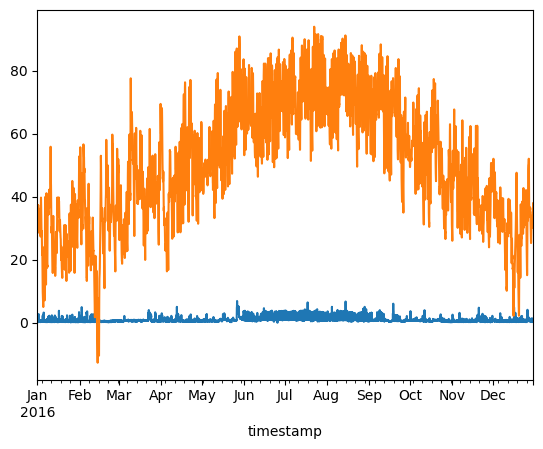

In [34]:
bldg_df['power'].plot()
bldg_df['temperature'].plot()